# CatBoostRegressor ve XGBoost Regressor algoritmalarını kullanarak oluşturulan model.


---


Bu modelde performansı arttırmak için özellik mühendisliği kullanıldı.
yine performans artması için veriyi fiyat bilgisine göre 3 parçaya bölerek eğitim ve testin daha doğru sonuçlar vermesi sağlandı.


---


Modeli 3 farklı veri seti ve 2 farklı algoritma ile çalıştırdık.



---






CatBoost Regressor;

- Karar ağaçları (decision trees) kullanarak model oluşturur.

- Modeli, zayıf tahminleri olan modelleri birbirini tamamlayacak şekilde art arda geliştirerek kurar (boosting).

- Kategorik verileri otomatik olarak işler – yani one-hot encoding gibi ön işleme ihtiyaç duymaz.

- Her model, bir öncekinin yaptığı hataları öğrenmeye çalışır.

Avantajları:

- Kategorik verileri doğrudan işleyebilir.

- Overfitting’e karşı dirençlidir (önlem mekanizmaları içerir).

- Hızlı ve yüksek doğruluk sağlar.

- Varsayılan ayarlarla bile çok başarılı sonuçlar verebilir.

Özellikle çok fazla kategorik özelliğin olduğu veri setlerinde kullanılır.



-------------------------------------------------------------------------------

XGBRegressor (Extreme Gradient Boosting)

XGBoost, en güçlü makine öğrenmesi algoritmalarından biridir. “Gradient Boosting” yaklaşımını daha hızlı ve daha kararlı hale getirir.

Nasıl Çalışır?

- Önce basit bir model oluşturur (örneğin, bir karar ağacı).

- Bu modelin hatalarını analiz eder.

- Sonraki modelleri bu hataları telafi etmeye yönelik geliştirir.

- Her adımda hatayı azaltmaya çalışan yeni bir model oluşturur.

- Tüm bu modellerin tahminleri birleştirilerek son tahmin yapılır.

Avantajları:

- Çok yüksek doğruluk sağlar.

- Overfitting’i önlemek için regularization (cezalandırma) kullanır.

- Çok büyük veri setlerinde bile verimli ve hızlı çalışır.

- Paralel işlem desteği sayesinde çok çekirdekli sistemlerde iyi performans gösterir.

Nerede Kullanılır?

- Büyük veri setlerinde ve yüksek doğruluk gereken uygulamalarda.

- Özellikle regresyon problemlerinde çok etkilidir.



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.2 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

In [4]:
file_path = '/content/drive/MyDrive/finalemlak2.xlsx'
df = pd.read_excel(file_path)


In [5]:
# Üst %0.5 fiyatları veri dışına çıkar (aykırı değerleri engellemek için)
df = df[df["price"] <= df["price"].quantile(0.995)]

- Bina fiyat değerlerine göre her bir veri için segmenti belirlendi.

In [6]:
df["segment"] = df["price"].apply(lambda x: "low" if x <= 2_000_000 else "mid" if x <= 5_000_000 else "high")


In [7]:
#  öznitelik mühendislşği
df["kat_farki"] = df["bina_kat_sayisi"] - df["daire_kati"]
df["cephe_sayisi"] = df[["kuzey", "guney", "dogu", "bati"]].sum(axis=1)
df["lux_mi"] = df[["goldeniz", "bahceli", "havuzlu"]].max(axis=1)


In [8]:
# Yeni öznitelikler:
df["fiyat_m2"] = df["price"] / df["grossSqm"]
df["kat_orani"] = df["daire_kati"] / (df["bina_kat_sayisi"] + 1)
df["oda_kategori"] = pd.cut(df["room"], bins=[0, 2, 3, 4, 5, 10],                 # oda sayısına göre gruplama
                            labels=["1-2", "3", "4", "5", "6+"])
df["bina_yukseklik"] = pd.cut(df["bina_kat_sayisi"], bins=[0, 3, 6, 10, 20],      # bina yüksekliğine göre gruplama
                              labels=["az", "orta", "yüksek", "çok yüksek"])


In [9]:

low_df = df[df["segment"] == "low"].dropna()  # Segmentlere ayır ve düşük segmentte eksik verileri temizle
mid_df = df[df["segment"] == "mid"]
high_df = df[df["segment"] == "high"]


In [10]:
# Veri model fonksiyon
def prepare(df_seg, log=True):
    y = np.log1p(df_seg["price"]) if log else df_seg["price"]                     # log dönüşüm sadece high segmentte uygulandı
    y_raw = df_seg["price"]
    X = df_seg.drop(columns=["price", "segment"])
    X = X.loc[:, X.nunique() > 1]                                                 # sabit sütunlar çıktı
    X_encoded = pd.get_dummies(X)                                                 # kategorik verileri sayısallaştı
    return train_test_split(X_encoded, y, y_raw, test_size=0.2, random_state=42), X_encoded.columns


In [11]:
# Segment modelleme döngüsü
segments = {"low": low_df, "mid": mid_df, "high": high_df}
segment_results = {}


In [12]:
for seg in segments:
    # boş verileri gözardı edicez.
    if segments[seg].empty:
        print(f"Uyarı: '{seg}' segmenti boş. Atlanıyor.")
        continue

    log = seg == "high"  # high segmentte log dönüşüm yapılır

    # Veriyi hazırla
    (X_train, X_test, y_train, y_test, y_raw_train, y_raw_test), cols = prepare(segments[seg], log=log)
    all_cols = sorted(set(cols)) # boş satırlar 0 ile doldurulur.
    X_train = X_train.reindex(columns=all_cols, fill_value=0)
    X_test = X_test.reindex(columns=all_cols, fill_value=0)

    # Verileri ölçeklendir
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Model seçimi
    if seg == "high":
        model = XGBRegressor(
            n_estimators=200, learning_rate=0.05, max_depth=5,
            subsample=0.9, colsample_bytree=0.8, random_state=42, verbosity=0
        )
    else:
        model = CatBoostRegressor(
            iterations=500, learning_rate=0.05, depth=6,
            loss_function='RMSE', verbose=0, random_seed=42
        )

    # Modeli eğit ve tahmin yap
    model.fit(X_train_scaled, y_train)
    y_pred = np.expm1(model.predict(X_test_scaled)) if log else model.predict(X_test_scaled)
    segment_results[seg] = (y_raw_test, y_pred)


In [13]:
# Tüm segment sonuçlarını birleştir
y_true_all = []
y_pred_all = []


In [14]:
for seg in ["low", "mid", "high"]:
    if seg in segment_results:
        y_true_all.append(segment_results[seg][0])
        y_pred_all.append(segment_results[seg][1])


In [15]:
y_true_all = np.concatenate(y_true_all)
y_pred_all = np.concatenate(y_pred_all)


In [16]:
# Genel doğruluk ve hata hesaplamaları
r2 = r2_score(y_true_all, y_pred_all)
mae = mean_absolute_error(y_true_all, y_pred_all)


In [17]:
# MAPE sadece 500K üstü evlerde hesaplanır
mask = y_true_all >= 500_000
filtered_true = y_true_all[mask]
filtered_pred = y_pred_all[mask]
mape = np.mean(np.abs((filtered_true - filtered_pred) / filtered_true)) * 100


In [18]:
# Her segment için ayrı başarı metrikleri
for seg in segment_results:
    yt, yp = segment_results[seg]
    print(f"[{seg.upper()}] R²: {r2_score(yt, yp):.3f} | MAE: {mean_absolute_error(yt, yp):,.0f} TL | MAPE: {np.mean(np.abs((yt - yp) / yt)) * 100:.2f} %")

# Genel başarı raporu
print("\n=== GENEL SONUÇLAR ===")
print(f"Test R²: {r2:.3f}")
print(f"Ortalama Hata (MAE): {mae:,.0f} TL")
print(f"Yüzde Hata (MAPE, 500K+): {mape:.2f} %")


[LOW] R²: 0.891 | MAE: 59,912 TL | MAPE: 7.57 %
[MID] R²: 0.976 | MAE: 68,582 TL | MAPE: 2.16 %
[HIGH] R²: 0.738 | MAE: 1,212,859 TL | MAPE: 7.31 %

=== GENEL SONUÇLAR ===
Test R²: 0.886
Ortalama Hata (MAE): 369,791 TL
Yüzde Hata (MAPE, 500K+): 3.86 %


In [19]:
print("Gerçek Değerler (y_true_all):", y_true_all.tolist())
print("Tahmin Değerler (y_pred_all):", y_pred_all.tolist())


Gerçek Değerler (y_true_all): [1995000, 1945000, 1720000, 1775000, 1700000, 1250000, 1800000, 1950000, 1595000, 2000000, 1875000, 1650000, 1550000, 1750000, 1890000, 1375000, 1070000, 1990000, 1825000, 1850000, 1650000, 1630000, 1375000, 1950000, 1950000, 1900000, 1500000, 2000000, 1925000, 1950000, 1200000, 1925000, 1825000, 2000000, 1585000, 1925000, 1750000, 1770000, 1200000, 1630000, 1750000, 1200000, 1990000, 1595000, 750000, 2000000, 1585000, 1780000, 1900000, 1535000, 1650000, 1150000, 1300000, 1850000, 2000000, 1500000, 1375000, 1000000, 1450000, 1750000, 1450000, 1980000, 1150000, 1750000, 1650000, 1800000, 1380000, 1950000, 190000, 1694000, 1850000, 1850000, 1900000, 1950000, 1495000, 1650000, 1695000, 1925000, 1920000, 800000, 1595000, 750000, 1850000, 1400000, 1600000, 1850000, 1550000, 1250000, 1850000, 1650000, 1240000, 1900000, 1925000, 1200000, 2000000, 1695000, 1450000, 2000000, 1595000, 1589000, 2550000, 3800000, 4050000, 2900000, 2150000, 4900000, 3075000, 2650000, 2

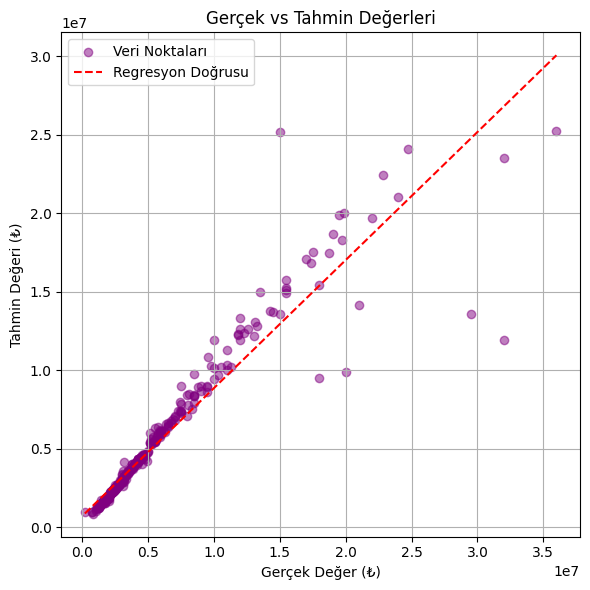

In [20]:
# Eğer bunlar NumPy array değilse listeyi array'e çevir:
y_true_arr = np.array(y_true_all[:2000])
y_pred_arr = np.array(y_pred_all[:2000])

# Grafik çizimi
plt.figure(figsize=(6, 6))
plt.scatter(y_true_arr, y_pred_arr, color='purple', alpha=0.5, label="Veri Noktaları")
plt.plot(
    np.unique(y_true_arr),
    np.poly1d(np.polyfit(y_true_arr, y_pred_arr, 1))(np.unique(y_true_arr)),
    color='red', linestyle='--', label="Regresyon Doğrusu"
)
plt.title("Gerçek vs Tahmin Değerleri")
plt.xlabel("Gerçek Değer (₺)")
plt.ylabel("Tahmin Değeri (₺)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


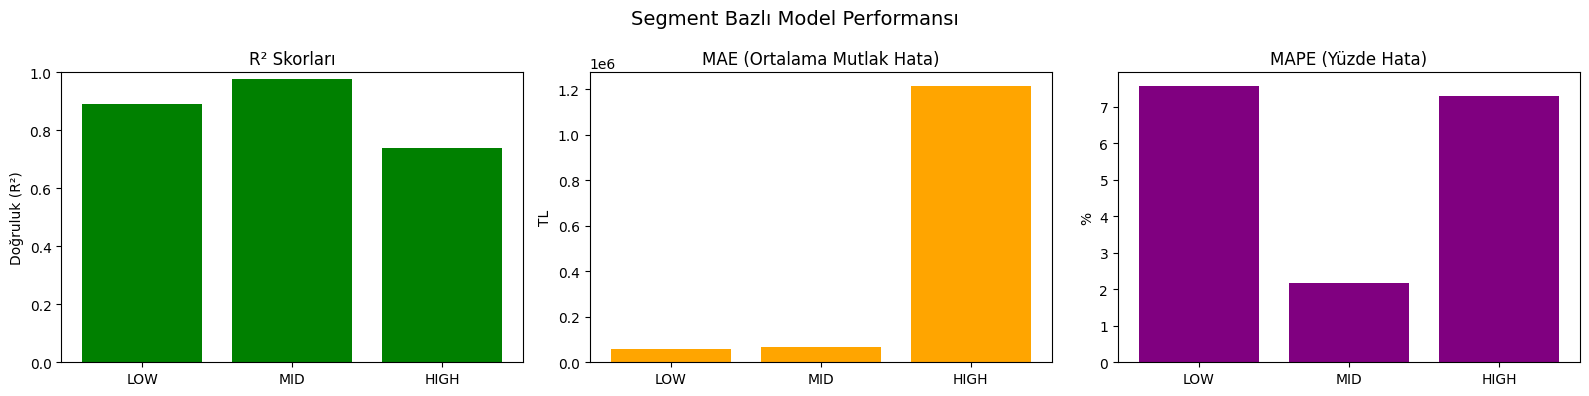

In [21]:
# Segment isimleri
segments = ["LOW", "MID", "HIGH"]

# R², MAE, MAPE değerleri
r2_scores = [0.891, 0.976, 0.738]
mae_scores = [59912, 68582, 1212859]
mape_scores = [7.57, 2.16, 7.31]

# Grafik boyutu
plt.figure(figsize=(16, 4))

# R² Bar Grafiği
plt.subplot(1, 3, 1)
plt.bar(segments, r2_scores, color="green")
plt.ylim(0, 1)
plt.title("R² Skorları")
plt.ylabel("Doğruluk (R²)")

# MAE Bar Grafiği
plt.subplot(1, 3, 2)
plt.bar(segments, mae_scores, color="orange")
plt.title("MAE (Ortalama Mutlak Hata)")
plt.ylabel("TL")

# MAPE Bar Grafiği
plt.subplot(1, 3, 3)
plt.bar(segments, mape_scores, color="purple")
plt.title("MAPE (Yüzde Hata)")
plt.ylabel("%")

plt.suptitle("Segment Bazlı Model Performansı", fontsize=14)
plt.tight_layout()
plt.show()

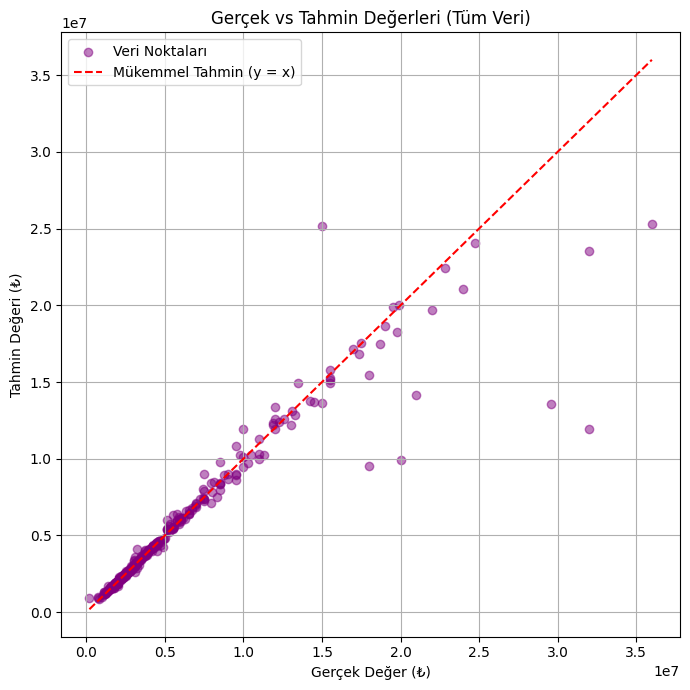

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Eğer bunlar listeyse, NumPy array'e çevir
y_true_arr = np.array(y_true_all)
y_pred_arr = np.array(y_pred_all)

# Grafik çizimi
plt.figure(figsize=(7, 7))
plt.scatter(y_true_arr, y_pred_arr, color='purple', alpha=0.5, label="Veri Noktaları")

# Mükemmel tahmin çizgisi (y = x)
min_val = min(y_true_arr.min(), y_pred_arr.min())
max_val = max(y_true_arr.max(), y_pred_arr.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label="Mükemmel Tahmin (y = x)")

plt.title("Gerçek vs Tahmin Değerleri (Tüm Veri)")
plt.xlabel("Gerçek Değer (₺)")
plt.ylabel("Tahmin Değeri (₺)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


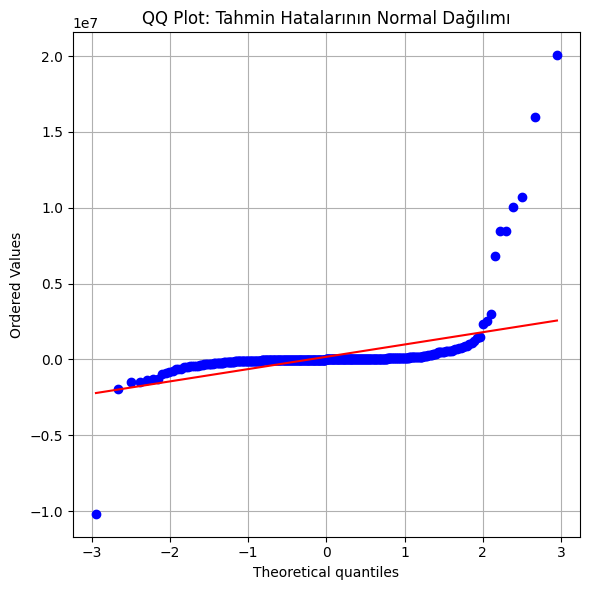

In [ ]:
import scipy.stats as stats


# Gerçek vs tahmin değerlerinin dağılımı
plt.figure(figsize=(6, 6))
stats.probplot(y_true_all - y_pred_all, dist="norm", plot=plt)
plt.title("QQ Plot: Tahmin Hatalarının Normal Dağılımı")
plt.grid(True)
plt.tight_layout()
plt.show()


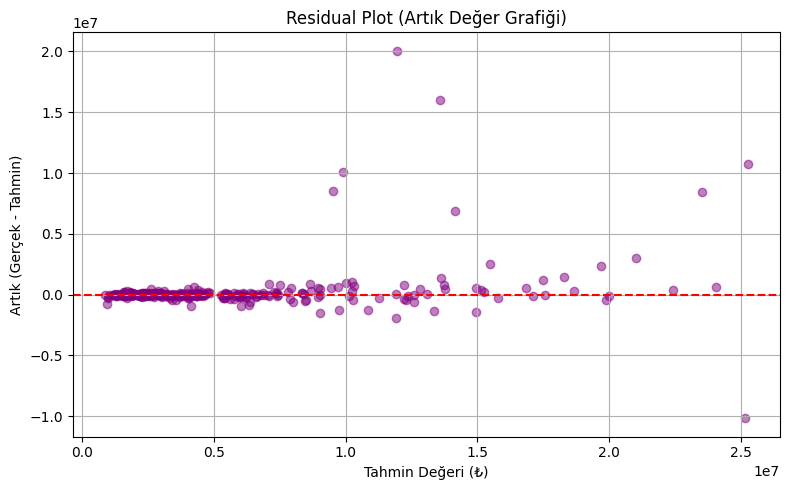

In [ ]:
residuals = np.array(y_true_all) - np.array(y_pred_all)

plt.figure(figsize=(8, 5))
plt.scatter(y_pred_all, residuals, alpha=0.5, color='purple')
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot (Artık Değer Grafiği)")
plt.xlabel("Tahmin Değeri (₺)")
plt.ylabel("Artık (Gerçek - Tahmin)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:


# --- Tüm veriyi yüklediğini varsayıyoruz: df ---
# Örneğin: df = pd.read_excel("veri.xlsx")

# --- Segmentlere ayır ---
low_df  = df[df["price"] < 2_000_000]
mid_df  = df[(df["price"] >= 2_000_000) & (df["price"] <= 4_500_000)]
high_df = df[df["price"] > 4_500_000]

# --- Tüm segmentleri birleştir ---
all_segments = pd.concat([low_df, mid_df, high_df])
all_segments = all_segments.drop(columns=["segment"], errors="ignore")  # segment sütunu varsa çıkar

# --- Hedef değişken (log dönüşümü) ---
y_all = all_segments["price"]
y_log = np.log1p(y_all)  # log1p, log(1 + x)

# --- Girdi değişkenleri ---
X_all = all_segments.drop(columns=["price"])
X_all = X_all.loc[:, X_all.nunique() > 1]  # sabit sütunları çıkar
X_encoded = pd.get_dummies(X_all)

# --- Ölçekleme (opsiyonel) ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# --- K-Fold Ayarı ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# --- Model tanımı ---
model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function='RMSE',
    verbose=0,
    random_seed=42
)

# --- Cross-validation ile ezber testi ---
scores = cross_val_score(model, X_scaled, y_log, cv=kf, scoring='r2')

# --- Sonuçları yazdır ---
print("Cross-Validation R² Skorları:", scores)
print("Ortalama R²:", np.mean(scores))
print("Standart Sapma:", np.std(scores))


Cross-Validation R² Skorları: [0.98927335 0.98224557 0.98250836 0.92579833 0.99116198]
Ortalama R²: 0.9741975180350961
Standart Sapma: 0.024459749632328668


In [23]:
print("Grafikteki en yüksek gerçek değer:", max(y_true_all))
print("Grafikteki en yüksek tahmin değeri:", max(y_pred_all))


Grafikteki en yüksek gerçek değer: 36000000
Grafikteki en yüksek tahmin değeri: 25278854.0


In [24]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 1. Yeni ilan verisi
sample_data = {
    'district': 'Arabacıalanı',
    'county': 'Serdivan',
    'residence': 'Daire',
    'heating': 'Kombi',
    'fuel': 'Doğalgaz',
    'build': 'Betonarme',
    'buildState': 'Sıfır',
    'furnished': 'false',
    'subCategory': 'Daire',
    'netSqm': 120,
    'grossSqm': 130,
    'age': 0,
    'room': 3,
    'bathRoom': 2,
    'livingRoom': 1,
    'bina_kat_sayisi' : 2,
    'daire_kati': 1,
    'kuzey':0,
    'guney':1,
    'dogu':0,
    'bati':0,
    'goldeniz':0,
    'bahceli':0,
    'havuzlu':0,
}

sample_df = pd.DataFrame([sample_data])

# 2. Eğitim verisinden aynı kategori için filtrele
subcat = sample_df['subCategory'].iloc[0]
train_group = df[df['subCategory'] == subcat]

X_train = train_group.drop(columns=['price'])
y_train = train_group['price']

# 3. Eksik sütunları tamamla
for col in X_train.columns:
    if col not in sample_df.columns:
        sample_df[col] = 'Hayır' if X_train[col].dtype == 'object' else 0

sample_df = sample_df[X_train.columns]

# 4. Pipeline kurulumu
categorical_cols = X_train.select_dtypes(include='object').columns.tolist()
numeric_cols = X_train.select_dtypes(include='number').columns.tolist()

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# 5. Modelini kendi modelinle değiştir
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state=42)

pipe = Pipeline([
    ('preprocess', preprocessor),
    ('model', model)
])

# 6. Eğit ve tahmin et
pipe.fit(X_train, y_train)
predicted_price = pipe.predict(sample_df)[0]

print(f"🏠 İlan tahmini fiyatı: {round(predicted_price):,} TL")

🏠 İlan tahmini fiyatı: 1,998,190 TL
